<a href="https://colab.research.google.com/github/Cazzarooo/Yolo_Mascara/blob/main/Yolo_Mascara.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Instalar dependências

_(Lembre-se de escolher GPU em tempo de execução se ainda não estiver selecionado. Tempo de execução -> Alterar tipo de tempo de execução -> Acelerador de hardware -> GPU)_

In [1]:
# clonar repositório YOLOv5
!git clone https://github.com/ultralytics/yolov5  # clone repo
%cd yolov5
!git reset --hard 064365d8683fd002e9ad789c1e91fa3d021b44f0

Cloning into 'yolov5'...
remote: Enumerating objects: 16867, done.
remote: Counting objects: 100% (42/42), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 16867 (delta 14), reused 28 (delta 4), pack-reused 16825 (from 1)
Receiving objects: 100% (16867/16867), 15.60 MiB | 15.96 MiB/s, done.
Resolving deltas: 100% (11554/11554), done.
/content/yolov5
HEAD is now at 064365d8 Update parse_opt() in export.py to work as in train.py (#10789)


In [2]:
# instale dependências conforme necessário
!pip install -qr requirements.txt
import torch

from IPython.display import Image, clear_output  # para exibir imagens
from utils.downloads import attempt_download  # para baixar modelos/conjuntos de dados

# clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 150.0 kB/s eta 0:00:00
Setup complete. Using torch 2.3.1+cu121 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15102MB, multi_processor_count=40)


In [3]:
pip install inference_sdk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.7/135.7 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.2/49.2 kB 5.3 MB/s eta 0:00:00


In [5]:
# importar o inference-sdk
from inference_sdk import InferenceHTTPClient

# inicializar o cliente
CLIENT = InferenceHTTPClient(
    api_url="https://detect.roboflow.com",
    api_key="owT4bua8xpydBMRzG0VY"
)

# inferir sobre uma imagem local
result = CLIENT.infer("/content/image_14.png", model_id="mascara-yw6sr/1")



In [6]:
# Resultado retornando JSON
print(result)

{'inference_id': '5907cfd0-b579-4564-82c5-7d3c47917abe', 'time': 0.05787639599998329, 'image': {'width': 500, 'height': 625}, 'predictions': [{'x': 234.0, 'y': 240.5, 'width': 220.0, 'height': 187.0, 'confidence': 0.9322510957717896, 'class': 'com_mascara', 'class_id': 0, 'detection_id': '5da5b8e7-93aa-468d-8e48-6d6c976f2afe'}]}


## Baixe um conjunto de dados

Adicione sua chave de API Roboflow abaixo para baixar o conjunto de dados padrão. Como alternativa, use o código fornecido pelo painel do Roboflow na etapa acima para carregar um conjunto de dados personalizado.

In [7]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="owT4bua8xpydBMRzG0VY")
project = rf.workspace("cazzaro-desktop").project("mascara-yw6sr")
version = project.version(1)
dataset = version.download("yolov5")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 5.1 MB/s eta 0:00:00
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Mascara-1 in yolov5pytorch:: 100%|██████████| 494/494 [00:00<00:00, 7995.62it/s]


In [8]:
%cd /content/yolov5

/content/yolov5


In [9]:
# este é o arquivo YAML que Roboflow escreveu para nós e que estamos carregando neste notebook com nossos dados
%cat {dataset.location}/data.yaml

names:
- com_mascara
- sem_mascara
nc: 2
roboflow:
  license: CC BY 4.0
  project: mascara-yw6sr
  url: https://universe.roboflow.com/cazzaro-desktop/mascara-yw6sr/dataset/1
  version: 1
  workspace: cazzaro-desktop
test: ../test/images
train: Mascara-1/train/images
val: Mascara-1/valid/images


# Definir configuração e arquitetura do modelo

Escreveremos um script yaml que define os parâmetros do nosso modelo, como o número de classes, âncoras e cada camada.

Você não precisa editar essas células, mas pode.

In [10]:
# definir o número de classes com base em YAML
import yaml
with open(dataset.location + "/data.yaml", 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])

In [11]:
#esta é a configuração do modelo que usaremos em nosso tutorial
%cat /content/yolov5/models/yolov5s.yaml

# YOLOv5 🚀 by Ultralytics, GPL-3.0 license

# Parameters
nc: 80  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]]

In [12]:
#personalize o writefile do iPython para que possamos escrever variáveis
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [13]:
%%writetemplate /content/yolov5/models/custom_yolov5s.yaml

# parameters
nc: {num_classes}
depth_multiple: 0.33
width_multiple: 0.50

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, BottleneckCSP, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, BottleneckCSP, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, BottleneckCSP, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, BottleneckCSP, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, BottleneckCSP, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

In [14]:
# treinar yolov5s em dados personalizados por 100 epochs
# cronometre seu desempenho
%%time
%cd /content/yolov5/
!python train.py --img 416 --batch 16 --epochs 100 --data {dataset.location}/data.yaml --cfg ./models/custom_yolov5s.yaml --weights '' --name yolov5s_results  --cache

/content/yolov5
2024-08-15 19:16:05.612426: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-15 19:16:05.854280: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-15 19:16:05.929529: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-15 19:16:06.081856: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-15 19:16:07.307250: W

# Avalie o desempenho do detector YOLOv5 personalizado

Você pode visualizar os gráficos de treinamento associados a um trabalho de treinamento na pasta /content/yolov5/runs/train/yolov5s_results/results.png.

As perdas de treinamento e as métricas de desempenho também são salvas no Tensorboard e também em um arquivo de log definido acima com o sinalizador --name quando treinamos. No nosso caso, chamamos isso de yolov5s_results.

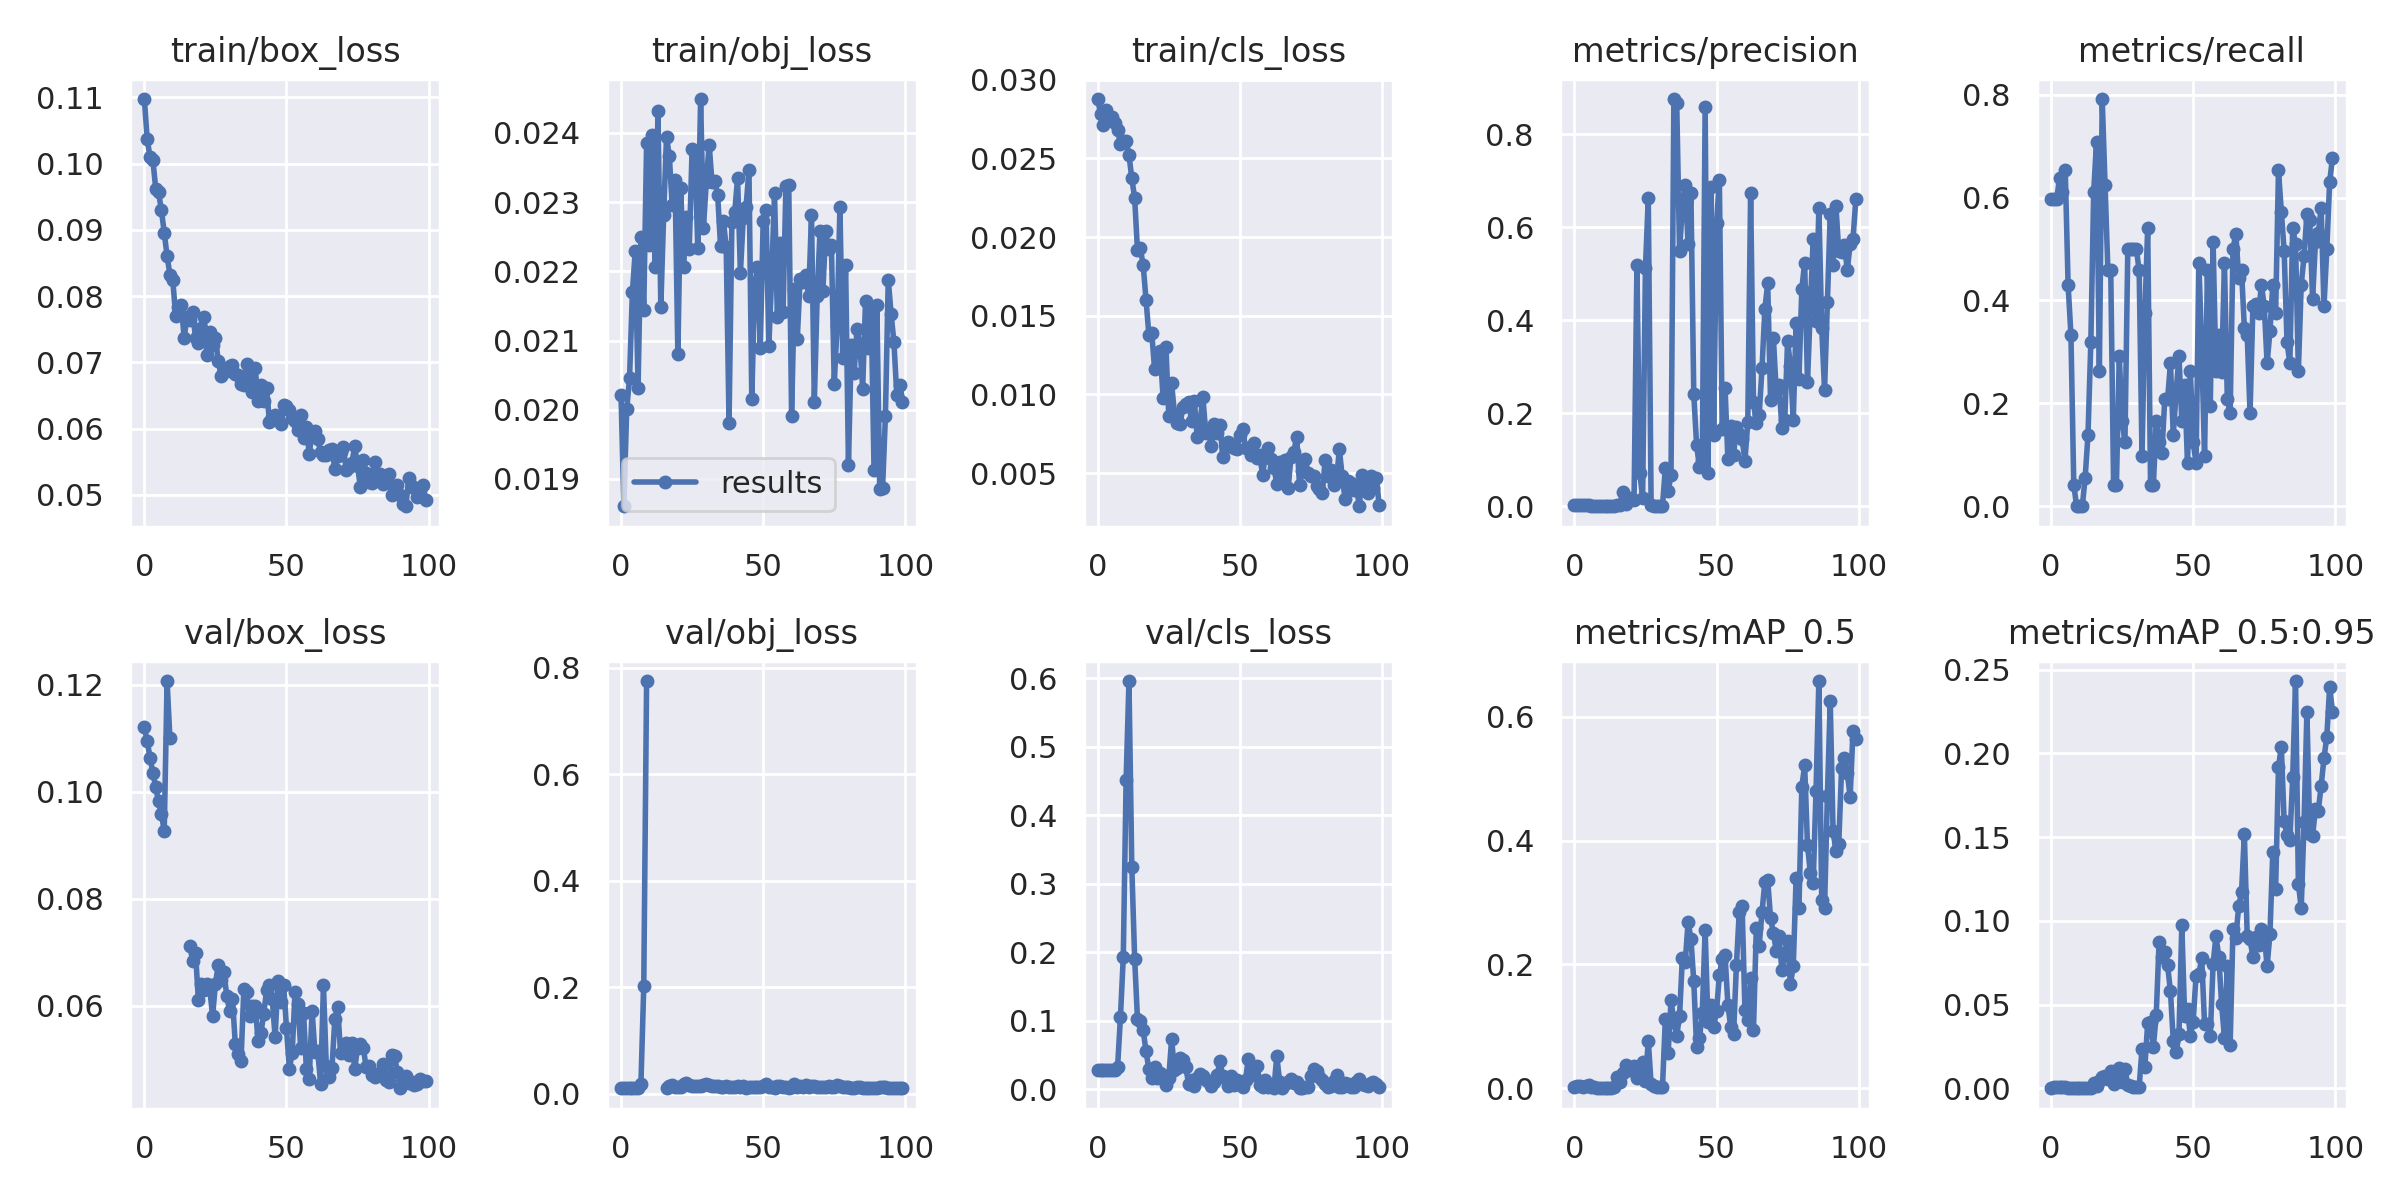

In [15]:
from utils.plots import plot_results  # plotar results.txt como results.png
Image(filename='/content/yolov5/runs/train/yolov5s_results/results.png', width=1000)  # ver resultados.png

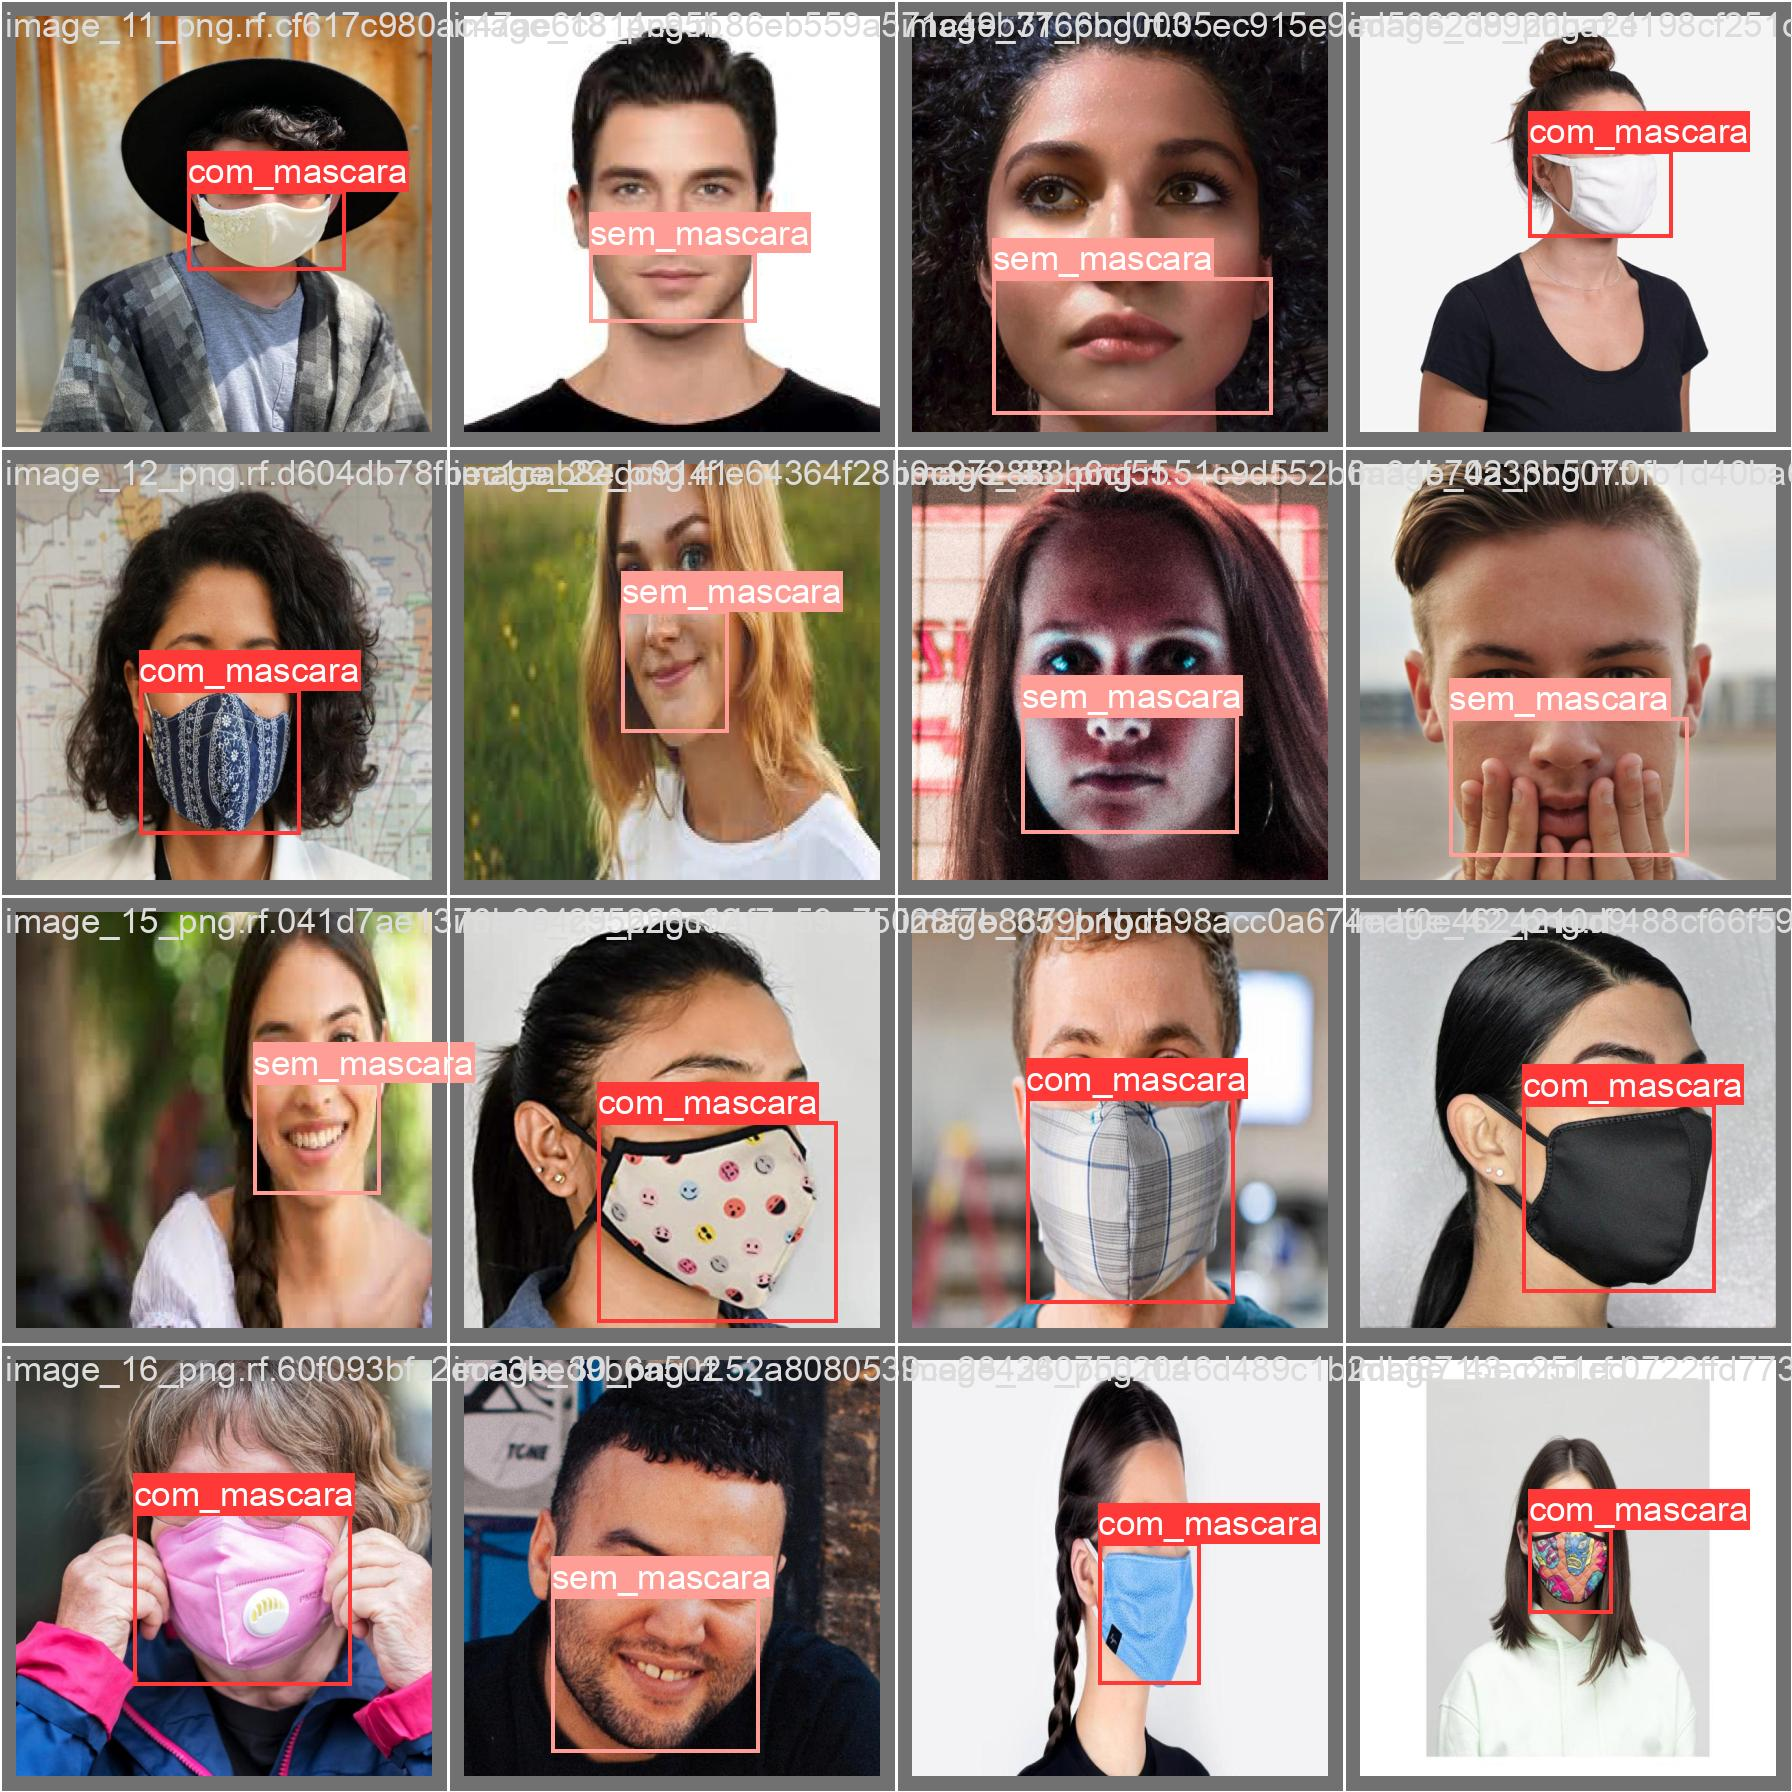

In [16]:
Image(filename='/content/yolov5/runs/train/yolov5s_results/val_batch0_labels.jpg', width=900)

GROUND TRUTH AUGMENTED TRAINING DATA:


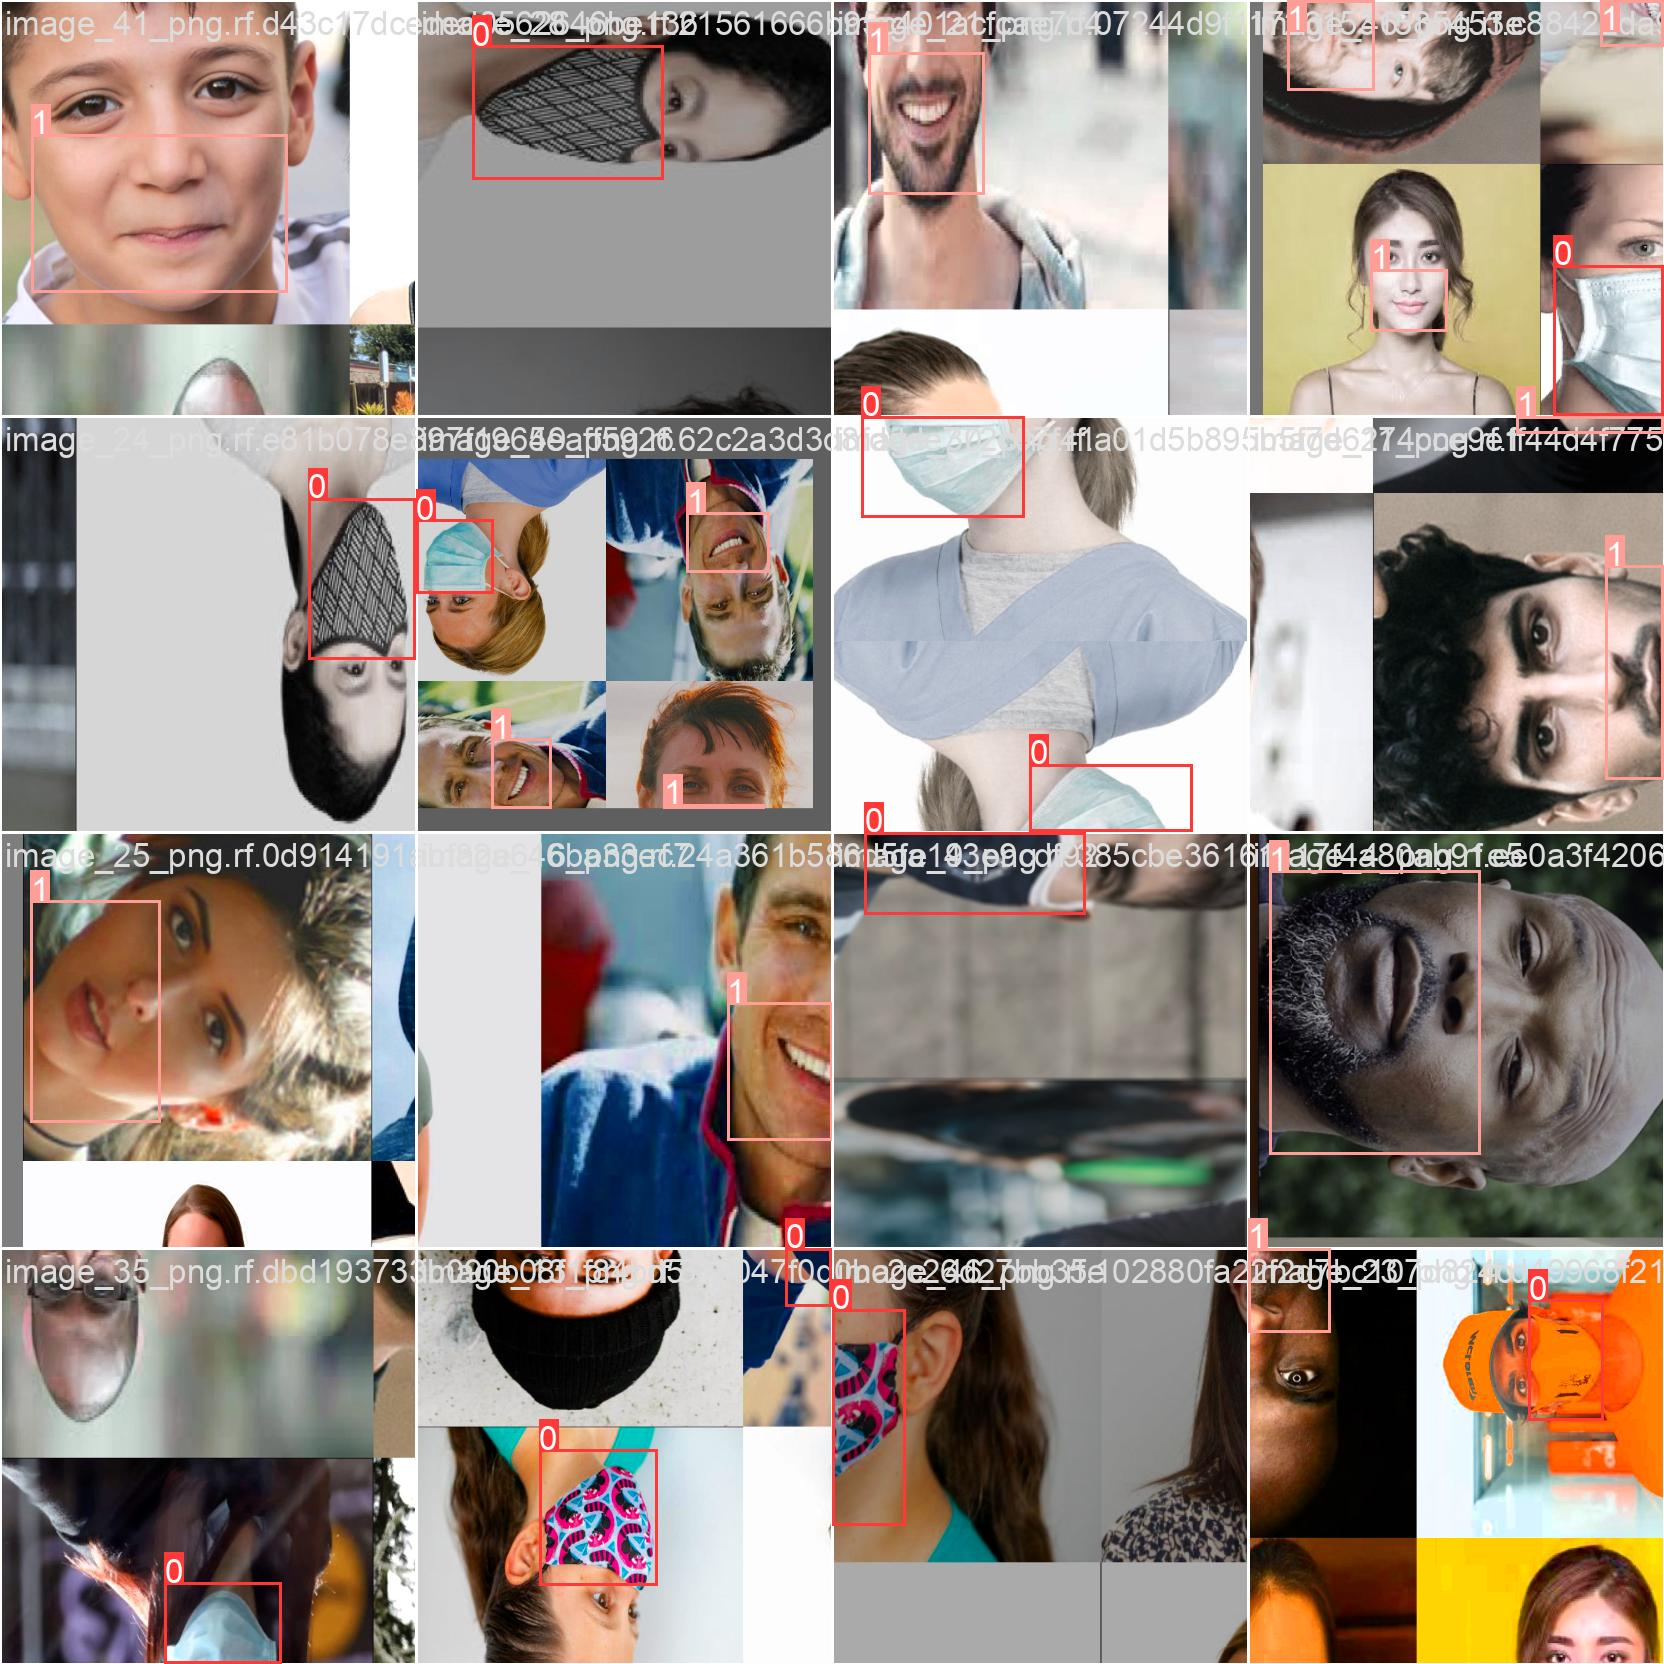

In [17]:
# imprima um exemplo de treinamento aumentado
print("GROUND TRUTH AUGMENTED TRAINING DATA:")
Image(filename='/content/yolov5/runs/train/yolov5s_results/train_batch0.jpg', width=900)

# Execute inferência com pesos treinados

A seguir, podemos executar inferência com um ponto de verificação pré-treinado em todas as imagens na pasta test/images para entender o desempenho de nosso modelo em nosso conjunto de teste.

In [18]:
# pesos treinados são salvos por padrão em nossa pasta de pesos
%ls runs/

train/


In [19]:
%ls runs/train/yolov5s_results/weights

best.pt  last.pt


No snippet abaixo, substitua Mascara-1 pelo nome da pasta na qual seu conjunto de dados está armazenado.

In [20]:
%cd /content/yolov5/
!python detect.py --weights runs/train/yolov5s_results/weights/best.pt --img 400 --conf 0.4 --source Mascara-1/test/images/

/content/yolov5
detect: weights=['runs/train/yolov5s_results/weights/best.pt'], source=Mascara-1/test/images/, data=data/coco128.yaml, imgsz=[400, 400], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-72-g064365d8 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
custom_YOLOv5s summary: 182 layers, 7249215 parameters, 0 gradients
WARNING ⚠️ --img-size [400, 400] must be multiple of max stride 32, updating to [416, 416]
image 1/10 /content/yolov5/Mascara-1/test/images/image_13_png.rf.29dcabf80b1dcf211ce48908e58d9175.jpg: 416x416 (no detections), 8.2ms
image 2/10 /content/yolov5/Mascara-1/test/images/image_20_png.rf.581edcf9355d972bdd34210a087ebd

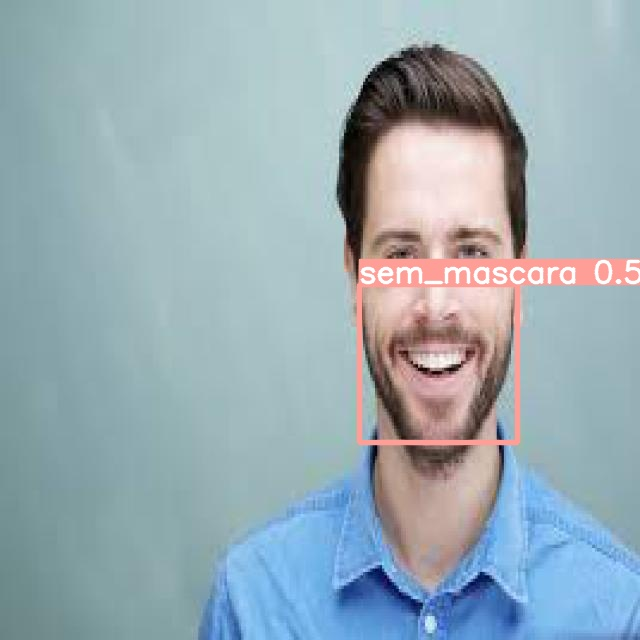

In [22]:
import glob
from IPython.display import Image, display

for imageName in glob.glob('/content/yolov5/runs/detect/exp/image_20_png.rf.581edcf9355d972bdd34210a087ebdcc.jpg')[:5]: #assumindo JPG
    display(Image(filename=imageName))